# Basic Research Ratio in VAR analysis

In [113]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from fredapi import Fred

import warnings
warnings.filterwarnings('ignore')

# 1. Data Transformation to Get B-Ratio from R&D and from patent

### 1.1 R&D B-ratio

In [114]:
# OECD Basic Research Ratio
RD_BRatio = pd.read_excel('Data/OECDBratio1980.xlsx')

In [115]:
# Mean
print(np.mean(RD_BRatio['Bratio']))
print(np.var(RD_BRatio['Bratio']))

0.4191832253116552
0.0015715734926652859


In [116]:
RD_BRatio['log_BRatio'] = np.log(RD_BRatio['Bratio'])
RD_BRatio = RD_BRatio[['Year', 'log_BRatio']]

### 1.2 Patent B-ratio

In [138]:
all_USpatent = pd.read_csv('Data/all_patent.csv')

b_patent1 = pd.read_csv('Data/1.csv')
b_patent2 = pd.read_csv('Data/2.csv')
b_patent3 = pd.read_csv('Data/3.csv')
b_patent = pd.concat([b_patent1, b_patent2, b_patent3])
b_patent =  b_patent.groupby(['Year']).count()

patent_df = pd.merge(all_USpatent, b_patent, on='Year').dropna()

patent_df['patent_bratio'] = np.log(patent_df['Name']/patent_df['Number'])
patent_df = patent_df[['Year', 'patent_bratio']]

### 1.3 BRatio Description

In [140]:
B_df = pd.merge(patent_df, RD_BRatio, on='Year', how='outer')

In [141]:
B_df

,Year,patent_bratio,log_BRatio
0,1963,NaN,-1.066201
1,1964,NaN,-1.030836
2,1965,NaN,-0.992599
3,1966,NaN,-0.968898
4,1967,NaN,-0.928273
...,...,...,...
56,2019,-3.585944,-0.808980
57,2020,-3.463343,-0.783906
58,2021,-3.259641,-0.800440
59,2022,-3.220561,-0.805908


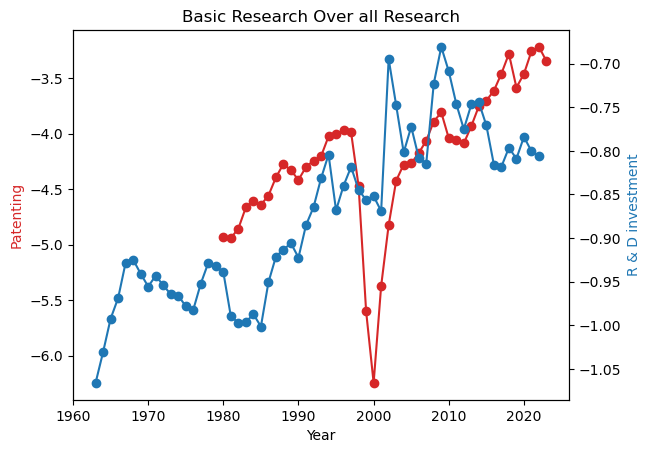

In [143]:
fig, ax1 = plt.subplots()

# Plot Temperature on the primary y-axis
ax1.plot(B_df['Year'], B_df['patent_bratio'], color='tab:red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Patenting', color='tab:red')

# Create a twin of the x-axis
ax2 = ax1.twinx()

# Plot Rainfall on the secondary y-axis
ax2.plot(B_df['Year'], B_df['log_BRatio'], color='tab:blue', marker='o')
ax2.set_ylabel('R & D investment', color='tab:blue')

plt.title('Basic Research Over all Research')
plt.show()

In [159]:
api = "f778a2073453c711be0c316569a478d2"
fred = Fred(api_key=api)

tfp = fred.get_series('RTFPNAUSA632NRUG') #Annual Total Factor Productivity
investment = fred.get_series('GPDIC1') #quarterly real domestic investment
wage = fred.get_series('LES1252881600Q') #quarterly real and seasonally adjusted wage
hours = fred.get_series('B4701C0A222NBEA') #Annual hours worked by full and part time employees


In [160]:
def transform(data):

    annual_data = {'year': data.resample('Y').mean().index.year,
                   'value':data.resample('Y').mean()}
    annual_data = pd.DataFrame(annual_data).reset_index(drop=True)
    annual_data['value'] = np.log(annual_data['value'])  #log transformation

    df = pd.DataFrame({'year': range(1963, 2023)})

    df = pd.merge(df, annual_data, on='year', how='left')
    return df #between 1963 to 2022

In [161]:
data = {'year':transform(tfp)['year'],
        'RD_bratio': B_df['log_BRatio'],
        'patent_bratio': B_df['patent_bratio'],
        'tfp': transform(tfp)['value'],
        'gdp': transform(gdp)['value'],
        'investment' : transform(investment)['value'],
        'wage': transform(wage)['value'],
        'hours': transform(hours)['value']}
data = pd.DataFrame(data)

In [162]:
data = data.dropna()
smdata = data.drop('year', axis=1)

### VAR Analysis

In [208]:
def var_model(data, var, var2):
    model = VAR(data)
    lag_order = model.select_order()  # 2 lags is ideal
    print(lag_order.summary())  
    print(f"Optimal lag order based on AIC: {lag_order.selected_orders['aic']}") #Akaike Information Criterion (AIC) and 
    var_model = model.fit(lag_order.selected_orders['aic'])
    print(var_model.summary())
    irf = var_model.irf(10)
    irf.plot(impulse=var, orth=False)
    plt.show()

    granger_test_x_y = var_model.test_causality(var, var2, kind='f')  # Test if 'x' Granger-causes 'y'
    granger_test_y_x = var_model.test_causality(var2, var, kind='f')  # Test if 'y' Granger-causes 'x'

    print("Granger Causality Test (x -> y):")
    print(granger_test_x_y.summary())
    
    print("\nGranger Causality Test (y -> x):")
    print(granger_test_y_x.summary())


### 2.1 Two Variables Analysis (BRatio and Productivity)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.648      -6.554    0.001297      -6.618
1       -8.262      -7.981   0.0002586      -8.172
2       -8.586      -8.119   0.0001878      -8.437
3      -8.812*     -8.158*  0.0001515*     -8.603*
4       -8.658      -7.818   0.0001804      -8.390
5       -8.517      -7.490   0.0002148      -8.189
6       -8.393      -7.179   0.0002560      -8.005
7       -8.268      -6.867   0.0003124      -7.820
8       -8.329      -6.741   0.0003270      -7.821
9       -8.589      -6.814   0.0002934      -8.021
10      -8.684      -6.722   0.0003305      -8.056
--------------------------------------------------
Optimal lag order based on AIC: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     13:47:03
--------------------------

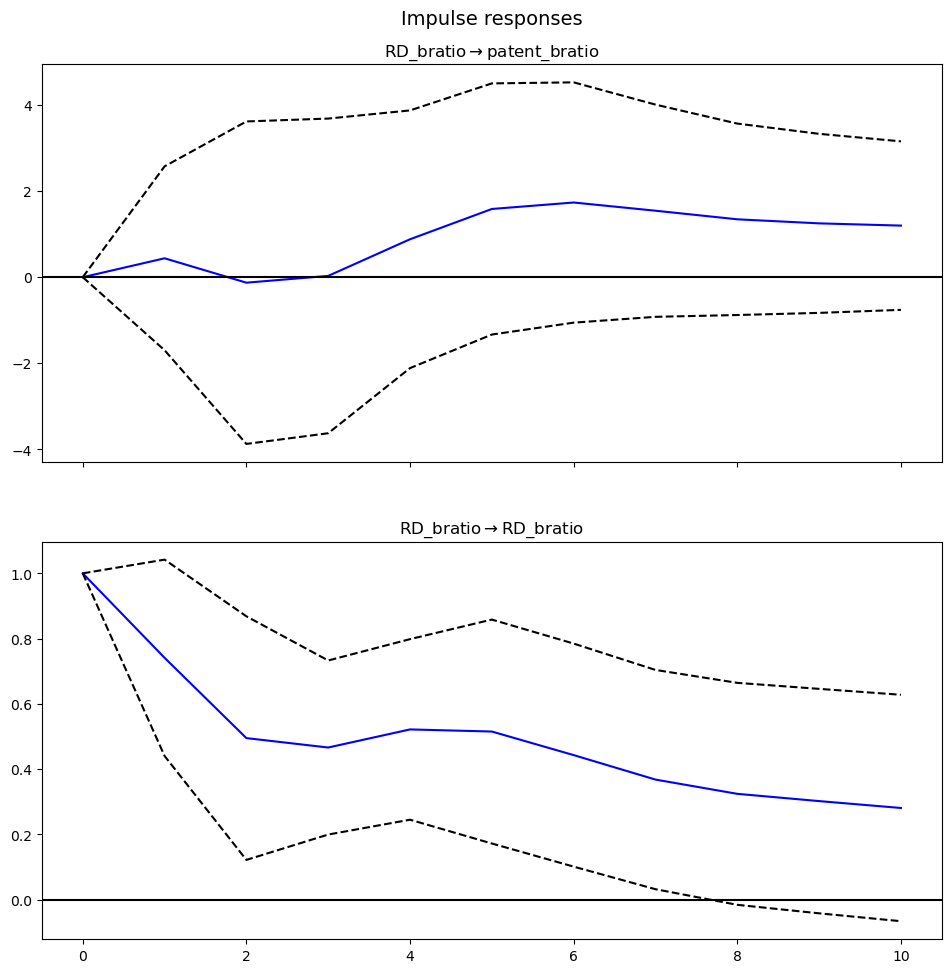

Granger Causality Test (x -> y):
Granger causality F-test. H_0: patent_bratio does not Granger-cause RD_bratio. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         5.110          2.758   0.003 (3, 60)
---------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: RD_bratio does not Granger-cause patent_bratio. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.7829          2.758   0.508 (3, 60)
---------------------------------------------


In [209]:
var_model(data[['patent_bratio', 'RD_bratio']], 'RD_bratio', 'patent_bratio')

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.72      -11.63   8.092e-06      -11.69
1      -15.99*     -15.71*  1.143e-07*     -15.90*
2       -15.86      -15.39   1.301e-07      -15.71
3       -15.68      -15.02   1.580e-07      -15.47
4       -15.50      -14.66   1.933e-07      -15.23
5       -15.34      -14.32   2.330e-07      -15.02
6       -15.19      -13.97   2.868e-07      -14.80
7       -14.97      -13.57   3.849e-07      -14.52
8       -14.98      -13.39   4.228e-07      -14.47
9       -14.84      -13.06   5.665e-07      -14.27
10      -14.89      -12.93   6.681e-07      -14.26
--------------------------------------------------
Optimal lag order based on AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     13:47:10
--------------------------

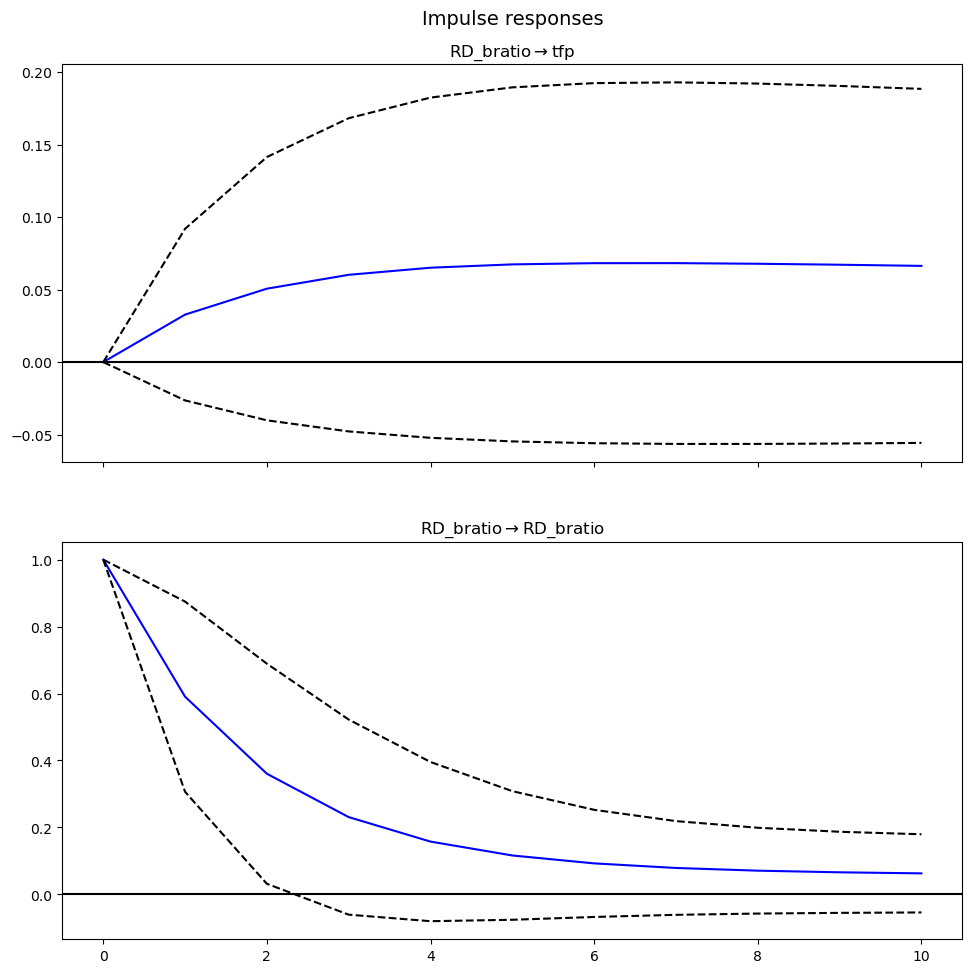

Granger Causality Test (x -> y):
Granger causality F-test. H_0: tfp does not Granger-cause RD_bratio. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         4.870          3.974   0.031 (1, 72)
---------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: RD_bratio does not Granger-cause tfp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         1.175          3.974   0.282 (1, 72)
---------------------------------------------


In [210]:
var_model(data[['tfp', 'RD_bratio']], 'RD_bratio', 'tfp')

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.712      -6.619    0.001216      -6.683
1       -11.83      -11.55   7.319e-06      -11.74
2      -12.33*     -11.86*  4.466e-06*     -12.18*
3       -12.14      -11.49   5.411e-06      -11.94
4       -12.04      -11.20   6.122e-06      -11.77
5       -11.81      -10.78   8.003e-06      -11.48
6       -11.72      -10.51   9.156e-06      -11.34
7       -11.72      -10.32   9.870e-06      -11.27
8       -11.84      -10.26   9.724e-06      -11.34
9       -11.82      -10.04   1.159e-05      -11.25
10      -12.30      -10.34   8.895e-06      -11.67
--------------------------------------------------
Optimal lag order based on AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     13:47:15
--------------------------

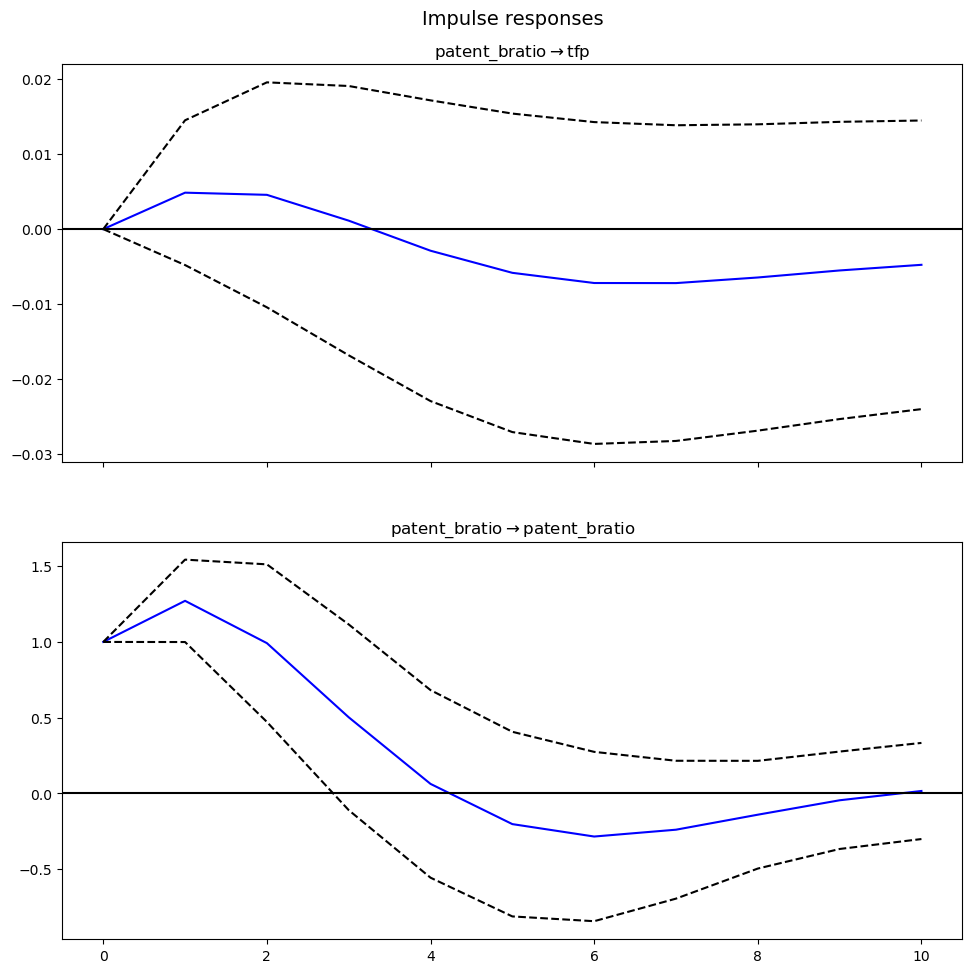

Granger Causality Test (x -> y):
Granger causality F-test. H_0: tfp does not Granger-cause patent_bratio. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         2.240          3.136   0.115 (2, 66)
---------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: patent_bratio does not Granger-cause tfp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.8512          3.136   0.432 (2, 66)
---------------------------------------------


In [211]:
var_model(data[['tfp', 'patent_bratio']], 'patent_bratio', 'tfp')

### 2.2. Three Variables (BRatio, Output and Productivity)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -18.67      -18.53   7.771e-09      -18.63
1      -25.01      -24.45   1.384e-11      -24.83
2      -25.66      -24.69   7.354e-12      -25.34
3      -25.47      -24.08   9.359e-12      -25.01
4      -25.10      -23.30   1.480e-11      -24.51
5      -25.13      -22.91   1.703e-11      -24.40
6      -25.39      -22.75   1.722e-11      -24.53
7      -25.89      -22.84   1.643e-11      -24.90
8      -27.31      -23.84   8.890e-12      -26.18
9     -33.52*     -29.63*  9.380e-14*     -32.25*
-------------------------------------------------
Optimal lag order based on AIC: 9
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     13:48:49
--------------------------------------------------------------------
No. of Equations:     

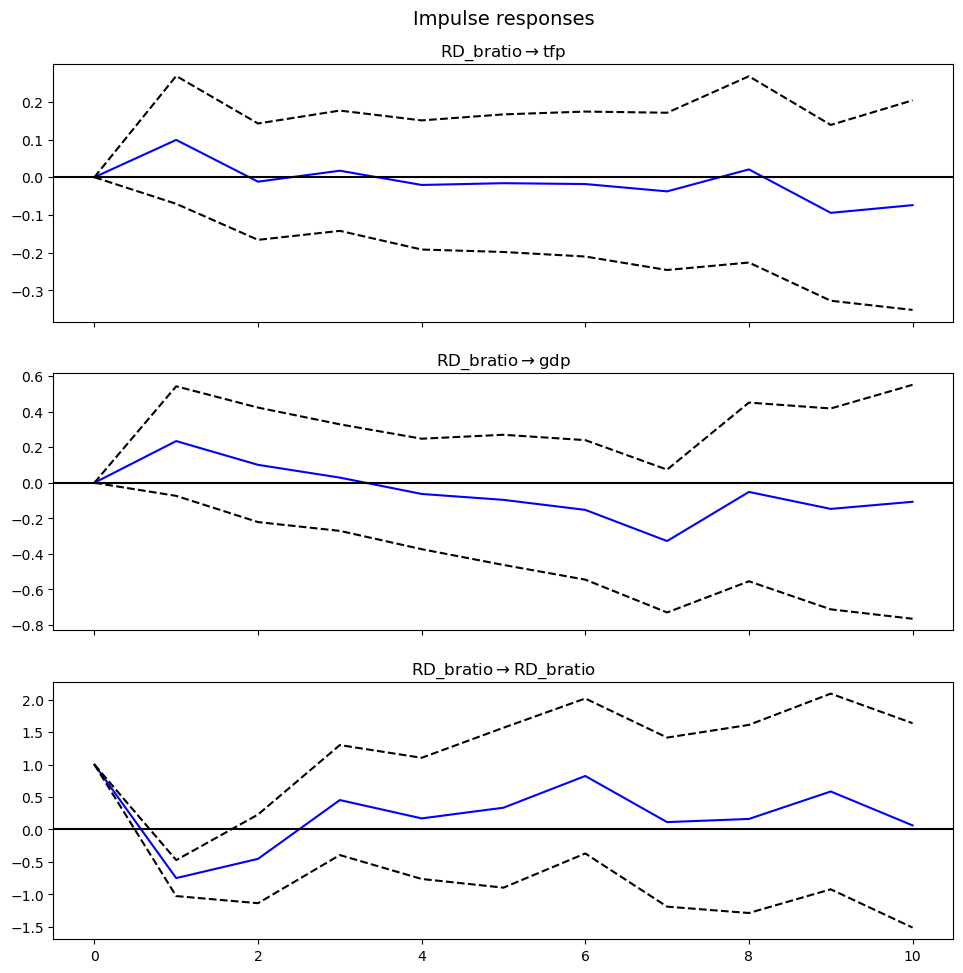

Granger Causality Test (x -> y):
Granger causality F-test. H_0: tfp does not Granger-cause RD_bratio. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
         11.71          3.179   0.001 (9, 9)
--------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: RD_bratio does not Granger-cause tfp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
        0.4527          3.179   0.873 (9, 9)
--------------------------------------------


In [212]:
var_model(data[['tfp', 'gdp', 'RD_bratio']], 'RD_bratio', 'tfp')

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -13.64      -13.50   1.194e-06      -13.59
1      -20.74      -20.18   9.890e-10      -20.56
2      -22.05      -21.08   2.726e-10      -21.73
3      -22.17      -20.78   2.530e-10      -21.72
4      -21.90      -20.09   3.652e-10      -21.31
5      -21.64      -19.42   5.562e-10      -20.92
6      -21.42      -18.78   9.139e-10      -20.56
7      -21.66      -18.61   1.130e-09      -20.67
8      -21.90      -18.43   1.994e-09      -20.76
9     -27.95*     -24.06*  2.459e-11*     -26.68*
-------------------------------------------------
Optimal lag order based on AIC: 9
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     13:49:02
--------------------------------------------------------------------
No. of Equations:     

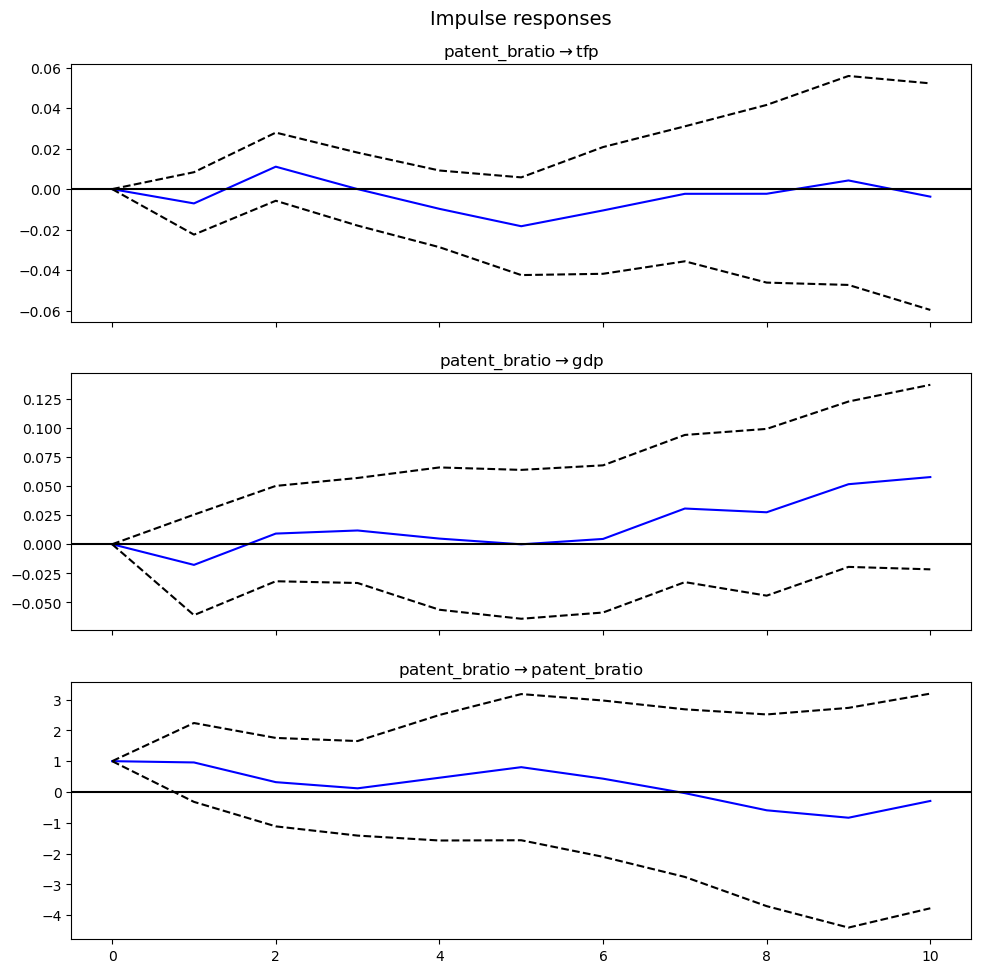

Granger Causality Test (x -> y):
Granger causality F-test. H_0: tfp does not Granger-cause patent_bratio. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
        0.3773          3.179   0.919 (9, 9)
--------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: patent_bratio does not Granger-cause tfp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
         1.335          3.179   0.337 (9, 9)
--------------------------------------------


In [213]:
var_model(data[['tfp', 'gdp', 'patent_bratio']], 'patent_bratio', 'tfp')

### 1.3 Five variables

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -31.33      -31.11   2.472e-14      -31.25
1      -42.15      -40.81   5.055e-19      -41.69
2      -43.38      -40.94   1.609e-19      -42.54
3      -45.00      -41.45   4.116e-20      -43.78
4      -44.76      -40.10   9.202e-20      -43.15
5     -47.53*     -41.75*  1.946e-20*     -45.53*
-------------------------------------------------
Optimal lag order based on AIC: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     13:54:25
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -41.7487
Nobs:                     35.0000    HQIC:                  -45.5315
Log likelihood:           713.385    FPE:                1.94584e-20
AIC:           

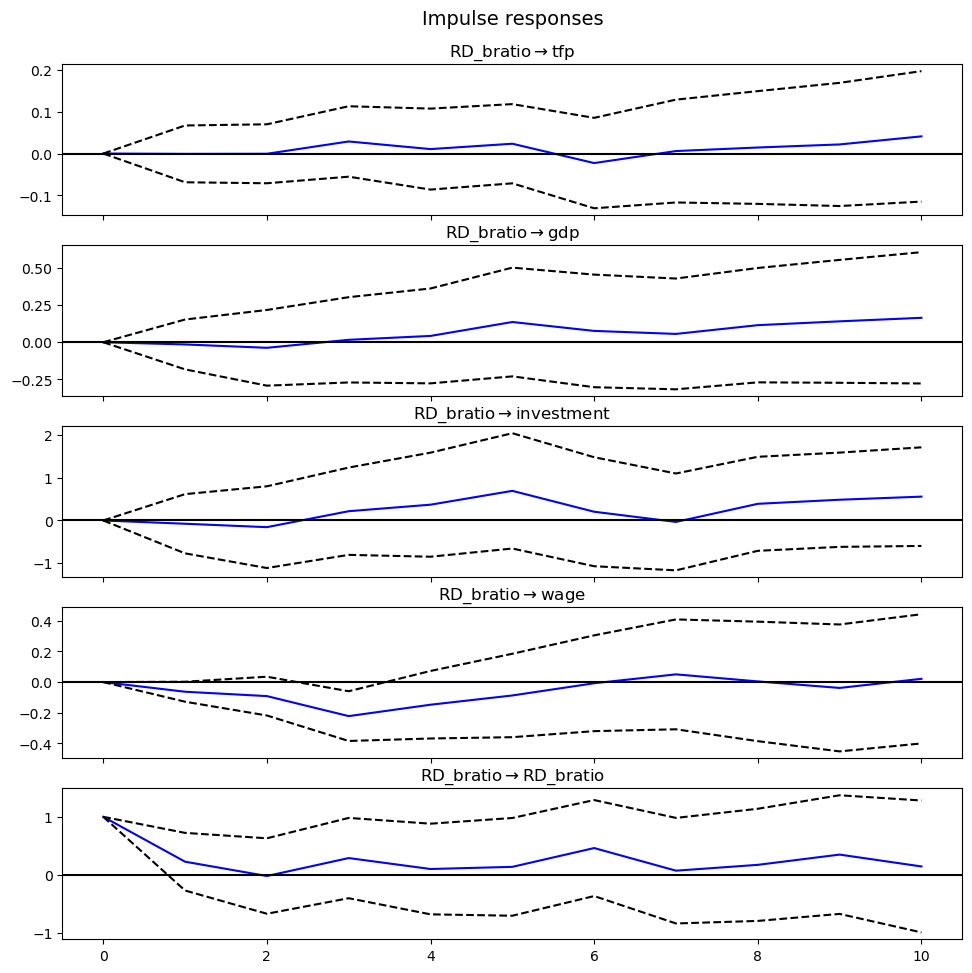

Granger Causality Test (x -> y):
Granger causality F-test. H_0: tfp does not Granger-cause RD_bratio. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.5724          2.422   0.721 (5, 45)
---------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: RD_bratio does not Granger-cause tfp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.6775          2.422   0.643 (5, 45)
---------------------------------------------


In [217]:
var_model(data[['tfp', 'gdp', 'investment', 'wage', 'RD_bratio']], 'RD_bratio', 'tfp')

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -26.30      -26.08   3.768e-12      -26.23
1      -38.62      -37.29   1.717e-17      -38.16
2      -39.85      -37.40   5.516e-18      -39.01
3      -41.51      -37.95   1.354e-18      -40.28
4      -41.98      -37.31   1.496e-18      -40.36
5     -44.65*     -38.87*  3.447e-19*     -42.66*
-------------------------------------------------
Optimal lag order based on AIC: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Dec, 2024
Time:                     13:53:57
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -38.8742
Nobs:                     35.0000    HQIC:                  -42.6570
Log likelihood:           663.082    FPE:                3.44720e-19
AIC:           

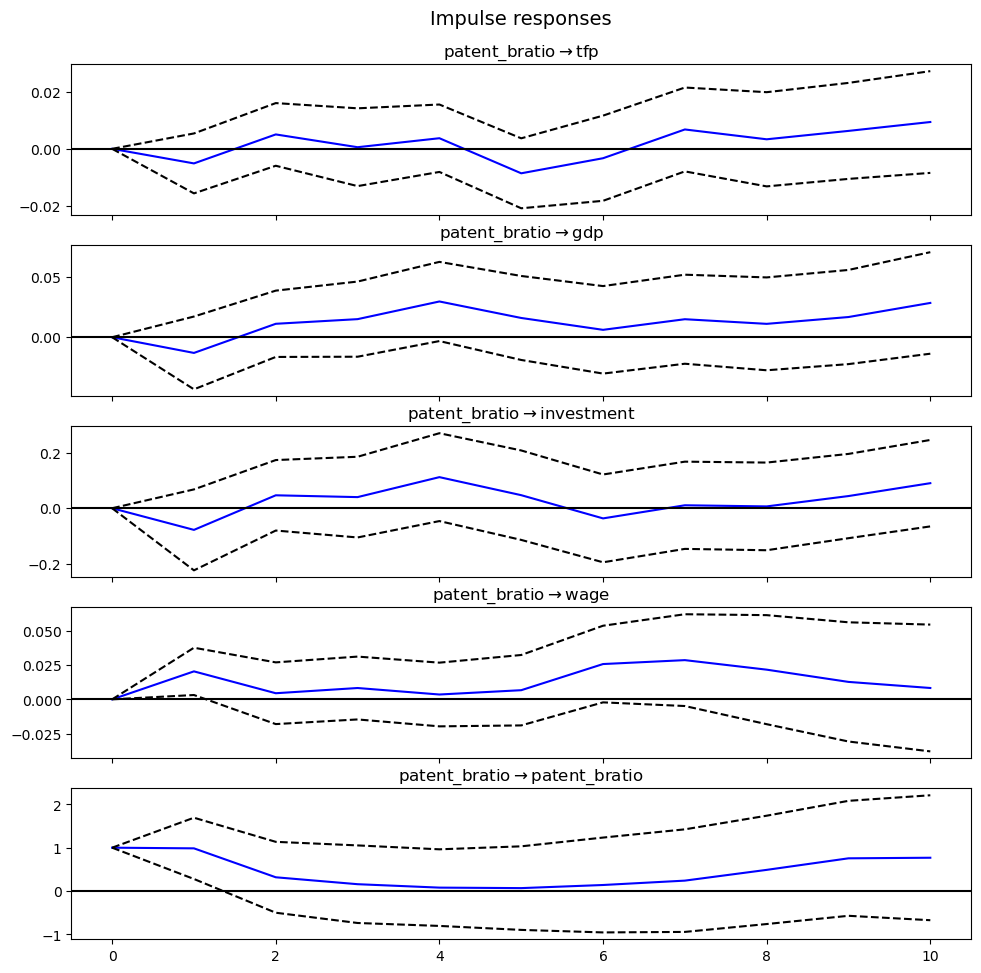

Granger Causality Test (x -> y):
Granger causality F-test. H_0: tfp does not Granger-cause patent_bratio. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.9789          2.422   0.441 (5, 45)
---------------------------------------------

Granger Causality Test (y -> x):
Granger causality F-test. H_0: patent_bratio does not Granger-cause tfp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         2.673          2.422   0.034 (5, 45)
---------------------------------------------


In [216]:
var_model(data[['tfp', 'gdp', 'investment', 'wage', 'patent_bratio']], 'patent_bratio', 'tfp')

In [205]:
model = sm.OLS(data['patent_bratio'], smdata['RD_bratio']).fit()  #USING PATENT DATA CAN CREATE MORE DATA POINTS ACROSS INDUSTRIES!!! HERE USING R&D CAN ONLY PROVIDE DATA FOR THE AGGREGATE ECONOMY
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          patent_bratio   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              2428.
Date:                Sun, 08 Dec 2024   Prob (F-statistic):                    9.70e-37
Time:                        13:41:09   Log-Likelihood:                         -32.582
No. Observations:                  40   AIC:                                      67.16
Df Residuals:                      39   BIC:                                      68.85
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Det. terms outside the coint. relation & lagged endog. parameters for equation patent_bratio
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
L1.patent_bratio     0.6730      0.152      4.426      0.000       0.375       0.971
L1.tfp             -17.9770      7.694     -2.337      0.019     -33.056      -2.898
L1.gdp              19.8718      5.282      3.762      0.000       9.518      30.225
L1.wage             -3.5920      3.598     -0.998      0.318     -10.643       3.459
L1.investment       -1.9042      0.889     -2.143      0.032      -3.646      -0.162
 Det. terms outside the coint. relation & lagged endog. parameters for equation tfp 
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
L1.patent_bratio     0.0050      0.005      1.005      0.

<Figure size 1200x600 with 0 Axes>

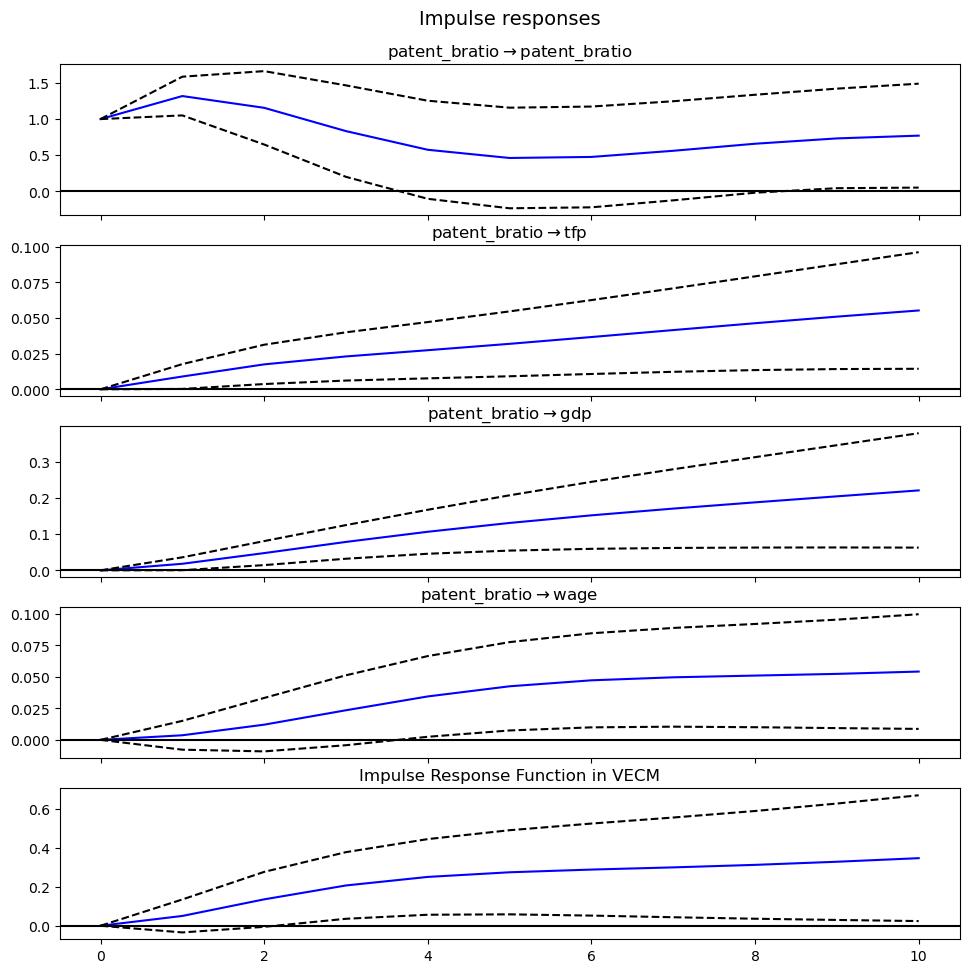

In [227]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Johansen Cointegration Test
df = data[['patent_bratio', 'tfp', 'gdp', 'wage', 'investment']]



# Fit VECM based on the cointegration rank
vecm_model = sm.tsa.VECM(df, coint_rank=1)  # Adjust coint_rank as necessary
vecm_result = vecm_model.fit()

# Summary of VECM results
print(vecm_result.summary())

# Impulse Response Functions
irf = vecm_result.irf(10)  # 10 periods ahead
plt.figure(figsize=(12, 6))
irf.plot(impulse='patent_bratio')
plt.title('Impulse Response Function in VECM')
plt.show()

### ADF test to test stationarity
Decision to use VAR or VECM

In [ ]:
def stationarity_test(data):
    adf_result = adfuller(RD_BRatio['Bratio'])
    
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:", adf_result[4])
    
    # Decision based on p-value
    alpha = 0.05  # significance level
    if adf_result[1] < alpha:
        print("Reject the null hypothesis (H0): The series is stationary.")
    else:
        print("Fail to reject the null hypothesis (H0): The series has a unit root and is non-stationary.")

In [ ]:
for col in ['bratio', 'tfp', 'gdp', 'investment', 'hours']:
    print(col)
    stationarity_test(data['bratio'])  #CONFIRMING NON-STATIONARITY

In [ ]:
model = VAR(smdata)
lag_order = model.select_order()  # 2 lags is ideal
print(lag_order.summary())  
print(f"Optimal lag order based on AIC: {lag_order.selected_orders['aic']}") #Akaike Information Criterion (AIC) and 

In [ ]:
var_model = model.fit(lag_order.selected_orders['aic'])
var_model.summary()

In [ ]:
irf = var_model.irf(10)
irf.plot(impulse='all_patent', orth=False)
plt.show()

In [ ]:
print("Testing if bratio Granger-causes TFP")
grangercausalitytests(smdata[['bratio', 'tfp']], 2, verbose=True)

print("\nTesting if TFP Granger-causes bratio")
grangercausalitytests(smdata[['tfp', 'bratio']], 2, verbose=True)

In [ ]:
print("Testing if bratio Granger-causes output")
grangercausalitytests(smdata[['bratio', 'gdp']], 1, verbose=True)

print("\nTesting if output Granger-causes bratio")
grangercausalitytests(smdata[['gdp', 'bratio']], 1, verbose=True)

In [ ]:
fevd = var_model.fevd(10)
print(fevd.summary())